# Learning Jammers: Loss Simulations
In this notebook, we will simulate different losses, compare their performance (BER) and have a look at their learned weights.

### Evaluation of different Losses

In [10]:
import os
# import drjit
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
import pickle

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [11]:
# common parameters
model_parameters = {}
jammer_parameters = {}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = 1.0
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["trainable"] = True
jammer_parameters["training_constraint"] = NonNegMaxMeanSquareNorm(1.0)
model_parameters["jammer_parameters"] = jammer_parameters

In [3]:
# needed, as keras MSE does not take |.|
abs_mse = lambda y_true, y_pred: tf.reduce_mean(tf.square(tf.abs(y_true - y_pred)))
abs_log = lambda y_true, y_pred: tf.reduce_mean(tf.math.log(tf.abs(y_true - y_pred) + 1))
# name, loss_fn, over symbols?, loss_over_logits
parameters = [
    ("L1 over symbols", negative_function(MeanAbsoluteError()), True, False),
    ("MSE over symbols", negative_function(abs_mse), True, False),
    ("L1 over bit estimates", negative_function(MeanAbsoluteError()), False, False),
    ("MSE over bit estimates", negative_function(MeanSquaredError()), False, False),
    ("BCE over bit estimates (logits)", BinaryCrossentropy(from_logits=True), False, True),
    ("log over bit estimates", negative_function(abs_log), False, False),
]

In [ ]:
sim.BATCH_SIZE = 2
for name, loss_fn, over_symbols, loss_over_logits in parameters:
    model = Model(**model_parameters, return_symbols=over_symbols)
    train_model(model,
                loss_fn=loss_fn,
                loss_over_logits=loss_over_logits,
                weights_filename=f"weights/{name}.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True)

In [30]:
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 128
# exclude BCE, as it is too bad
parameters = [x for x in parameters if "BCE" not in x[0]]
model_parameters["return_symbols"] = False
jammer_parameters["trainable"] = False
for name, loss_fn, over_symbols, loss_over_logits in parameters:
    filename = f"weights/{name}.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, name, add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.4078e-01 | 1.0000e+00 |    10651119 |    44236800 |        19200 |       19200 |        29.0 |reached max iter       
   -3.667 | 2.1649e-01 | 1.0000e+00 |     9576944 |    44236800 |        19200 |       19200 |        23.8 |reached max iter       
   -2.333 | 1.9626e-01 | 1.0000e+00 |     8681905 |    44236800 |        19200 |       19200 |        23.6 |reached max iter       
     -1.0 | 1.7921e-01 | 1.0000e+00 |     7927807 |    44236800 |        19200 |       19200 |        23.3 |reached max iter       
    0.333 | 1.6346e-01 | 1.0000e+00 |     7230747 |    44236800 |        19200 |       19200 |        23.6 |reached max iter       
    1.667 | 1.5077e-01 | 1.0000e+00 |     6669642 |    44236800 |        19200 |     

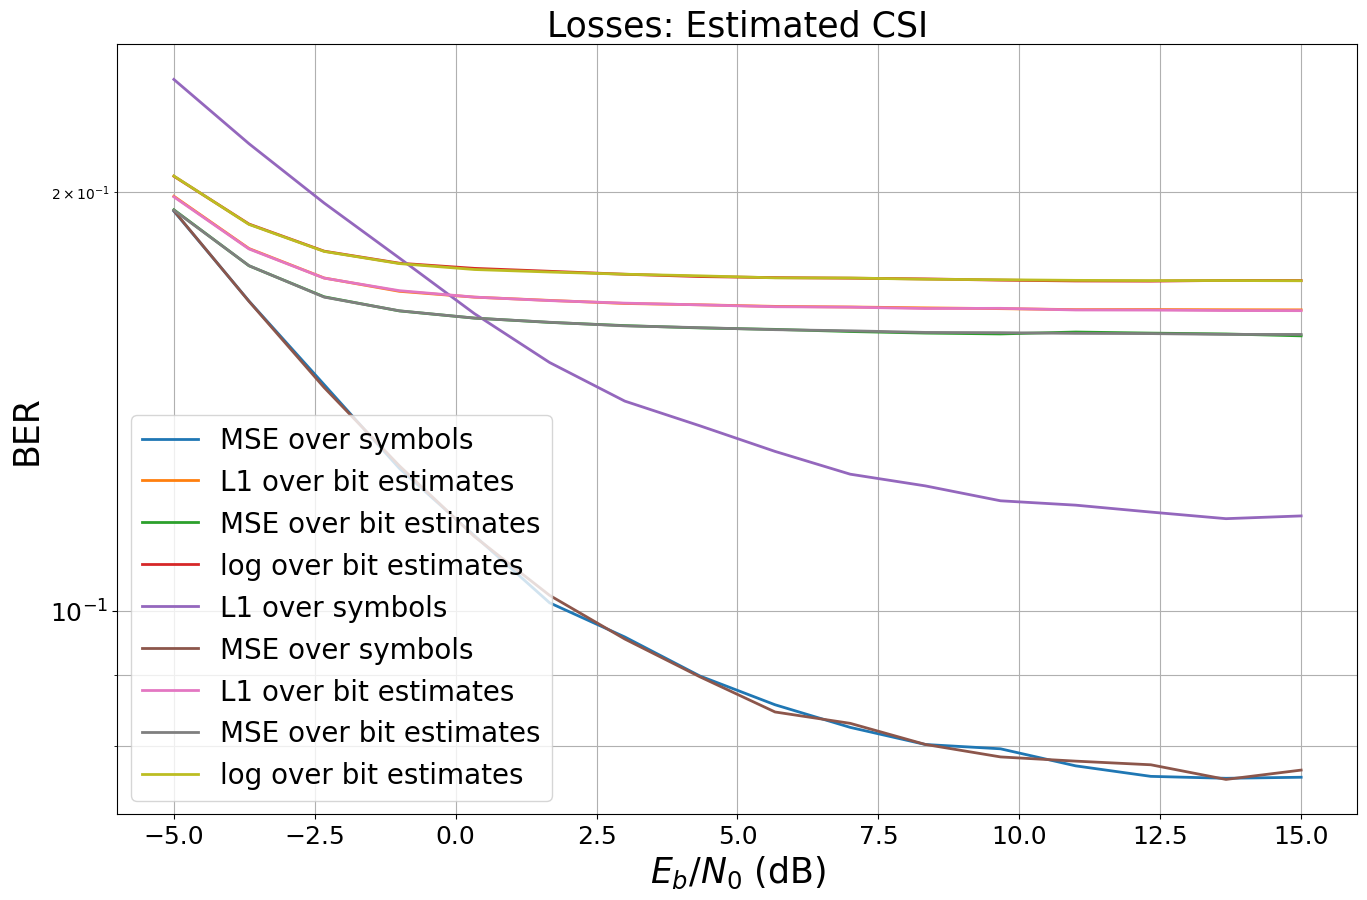

In [31]:
ber_plots.title = "Losses: Estimated CSI"
ber_plots(show_bler=False)
import pickle
with open("bers/report/learning/losses_5dB-SNR_train.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

### L1 Loss over Symbol Error, Different Constellation Sizes

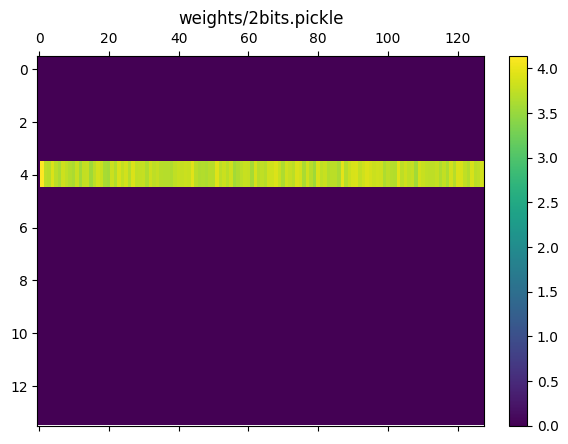

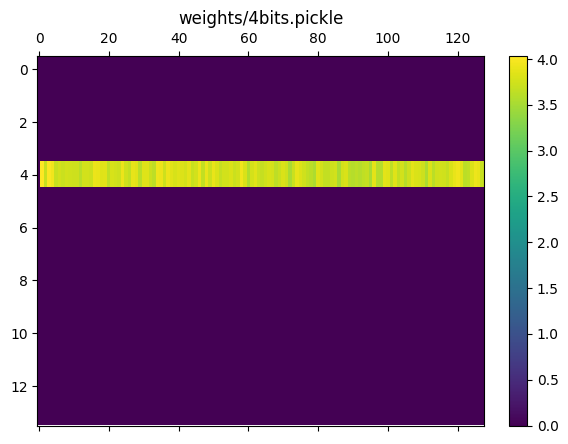

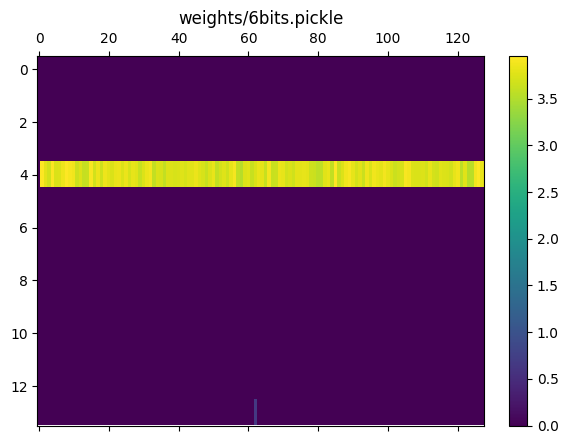

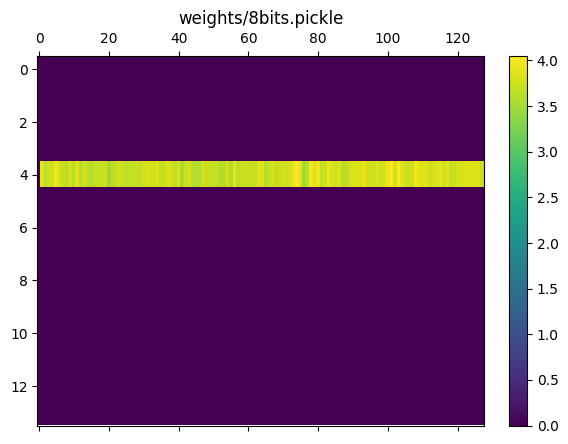

In [3]:
sim.BATCH_SIZE = 2
loss = negative_function(MeanAbsoluteError())
jammer_parameters["trainable"] = True
# 4, 16, 64, 256 - QAM
bits_per_symbol = [2, 4, 6, 8]
for b in bits_per_symbol:
    model = Model(**model_parameters, num_bits_per_symbol=b, return_symbols=True)
    train_model(model,
                loss_fn=loss,
                loss_over_logits=False,
                weights_filename=f"weights/{b}bits.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True,
                num_iterations=2000)

### Training L1-bit-error on different SNRs

In [ ]:
sim.BATCH_SIZE = 2
loss = negative_function(MeanAbsoluteError())
snrs = np.arange(-5, 10.5, 2.5, dtype=np.float32)
jammer_parameters["trainable"] = True
for ebno_db in snrs:
    model = Model(**model_parameters)
    train_model(model,
                loss_fn=loss,
                loss_over_logits=False,
                weights_filename=f"weights/{ebno_db}db.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True,
                num_iterations=2000,
                ebno_db=ebno_db)

In [33]:
ber_plots.reset()
sim.MAX_MC_ITER = 100
sim.BATCH_SIZE = 128
jammer_parameters["trainable"] = False
snrs = np.arange(-5, 10.5, 2.5, dtype=np.float32)
for ebno_db in snrs:
    filename = f"weights/{ebno_db}db.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{ebno_db}db")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.3520e-01 | 1.0000e+00 |     9885522 |    29491200 |        12800 |       12800 |        21.9 |reached max iter       
   -3.667 | 3.3120e-01 | 1.0000e+00 |     9767441 |    29491200 |        12800 |       12800 |        15.9 |reached max iter       
   -2.333 | 3.2845e-01 | 1.0000e+00 |     9686351 |    29491200 |        12800 |       12800 |        16.2 |reached max iter       
     -1.0 | 3.2630e-01 | 1.0000e+00 |     9622883 |    29491200 |        12800 |       12800 |        16.2 |reached max iter       
    0.333 | 3.2495e-01 | 1.0000e+00 |     9583100 |    29491200 |        12800 |       12800 |        15.9 |reached max iter       
    1.667 | 3.2404e-01 | 1.0000e+00 |     9556267 |    29491200 |        12800 |     

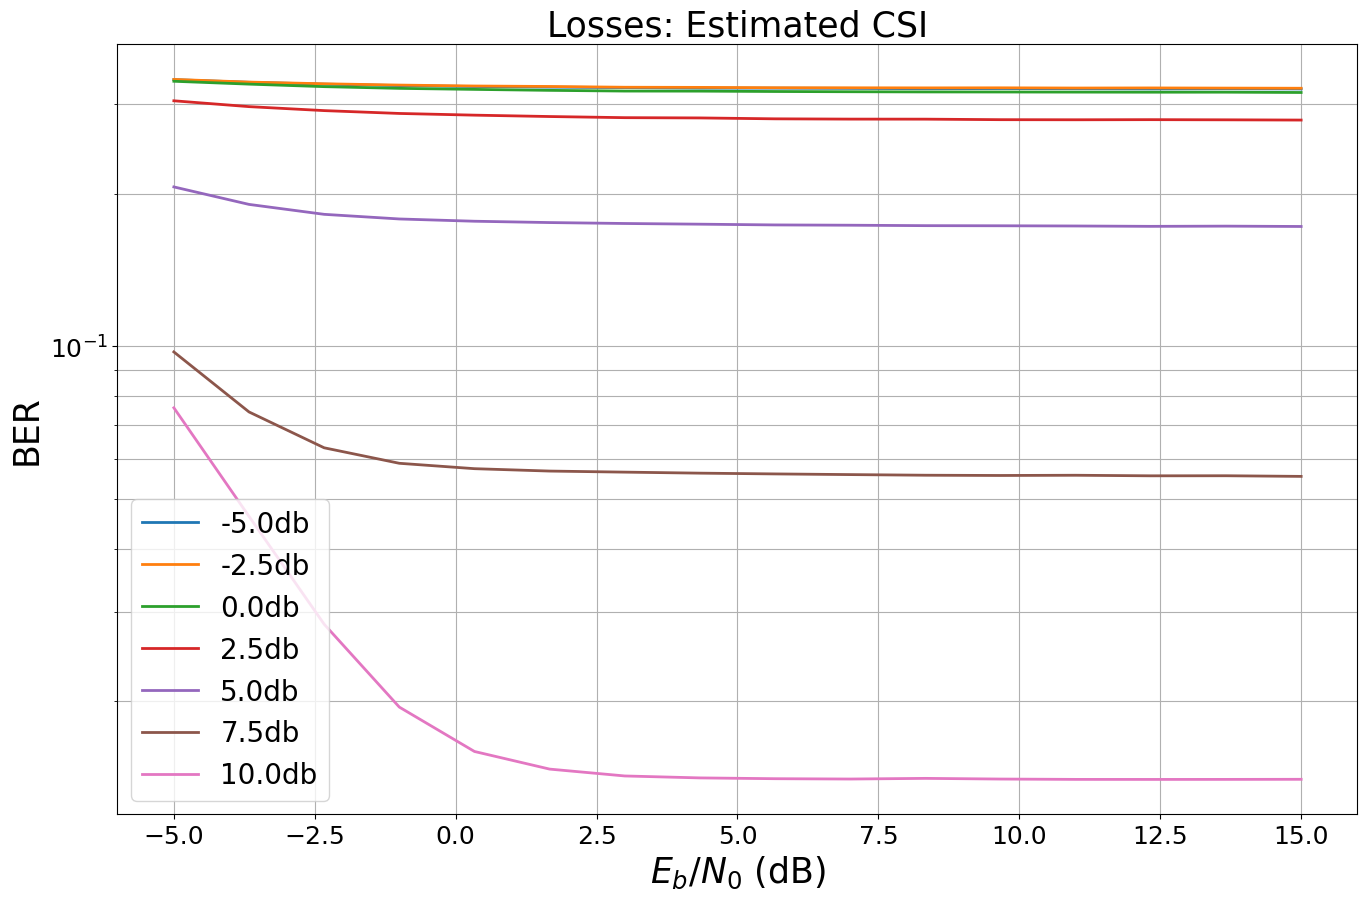

In [34]:
ber_plots.title = "Losses: Estimated CSI"
ber_plots()
import pickle
with open("bers/report/learning/l1_SNRs_train.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

### Training over Symbol Time only (14 Parameters, at 0dB ebno_db)
The following losses were all only trained over Symbols (one weight per symbol-time) only, and at 0dB UE-BS SNR

In [35]:
ber_plots.reset()
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 128
# exclude BCE, as it is too bad
parameters = [x for x in parameters if "BCE" not in x[0]]
model_parameters["return_symbols"] = False
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
for name, loss_fn, over_symbols, loss_over_logits in parameters:
    filename = f"weights/{name} symbol_weights.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, name)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.4175e-01 | 1.0000e+00 |    10694294 |    44236800 |        19200 |       19200 |        30.9 |reached max iter       
   -3.667 | 2.1761e-01 | 1.0000e+00 |     9626289 |    44236800 |        19200 |       19200 |        24.6 |reached max iter       
   -2.333 | 1.9720e-01 | 1.0000e+00 |     8723353 |    44236800 |        19200 |       19200 |        24.9 |reached max iter       
     -1.0 | 1.7836e-01 | 1.0000e+00 |     7890134 |    44236800 |        19200 |       19200 |        24.7 |reached max iter       
    0.333 | 1.6441e-01 | 1.0000e+00 |     7272999 |    44236800 |        19200 |       19200 |        24.8 |reached max iter       
    1.667 | 1.5236e-01 | 1.0000e+00 |     6739895 |    44236800 |        19200 |     

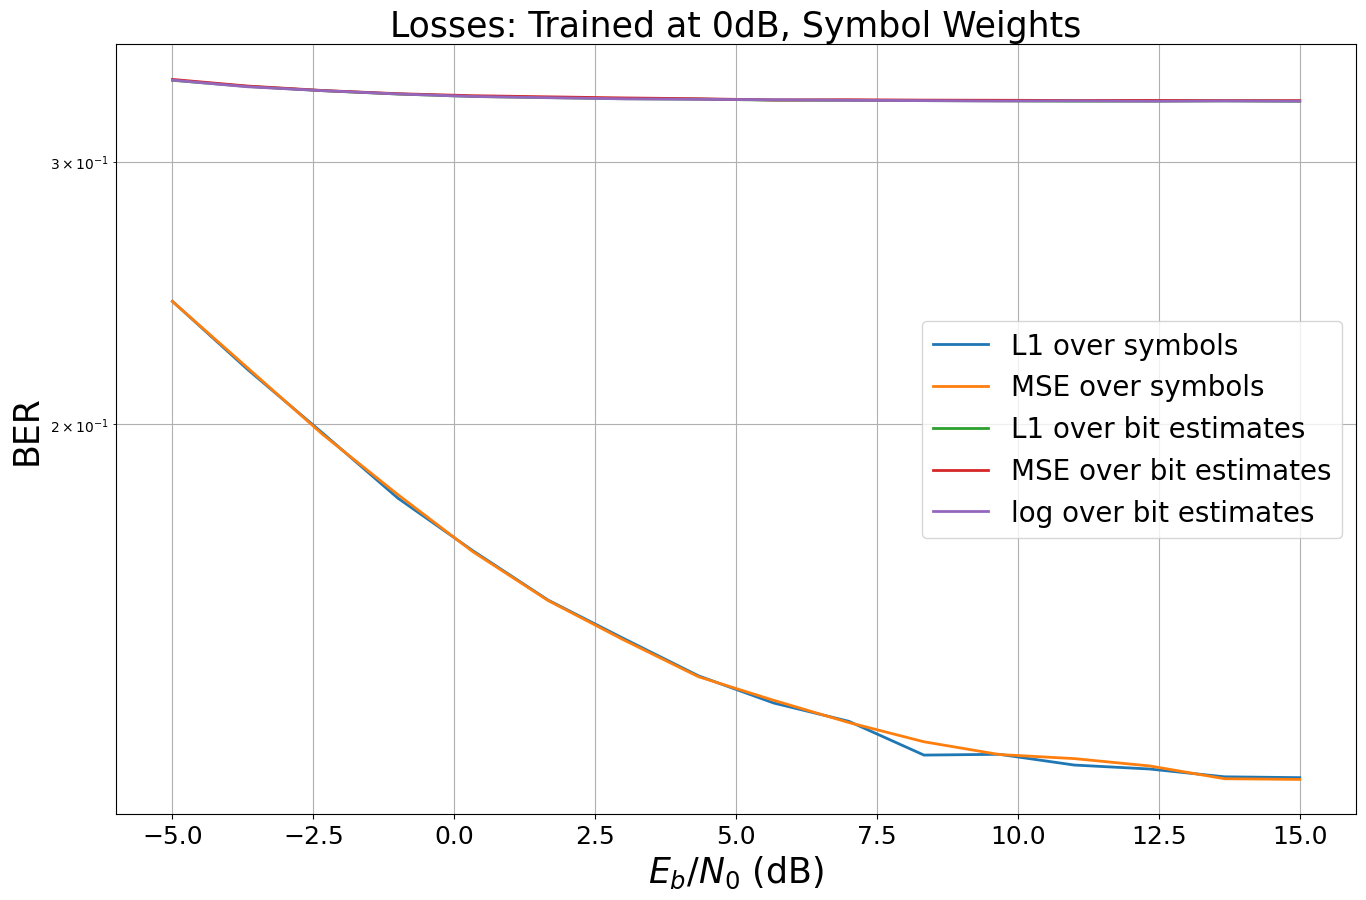

In [36]:
ber_plots.title = "Losses: Trained at 0dB, Symbol Weights"
ber_plots()
import pickle
with open("bers/report/learning/losses_0dB-SNR_train.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

### Training over Non-silent Symbols only
To maybe prevent local maximum we are sliding into when learning to not jam silent symbols